# 4 - Otimização de modelos

Concluída a fase de modelagem, vimos que dois modelos, regressão logística e XGBoost, preveem adequadamente os resultados de testes de COVID. 

Vamos agora tentar otimizá-los.

Nessa fase, buscaremos os melhores parâmetros para utilizar com estes modelos, a fim de determinar o modelo final a ser utilizado para predição de novos dados.

In [1]:
# para carregar a base de dadas limpa
import pickle

import numpy as np
import pandas as pd
from scipy import stats as spst

from pprint import pprint

# gráficos
import seaborn as sns
from matplotlib import rcParams, pyplot as plt

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

# warnings
import warnings
warnings.filterwarnings("ignore")

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import scripts.plots as splt, scripts.metrics as smetrics
os.chdir(cwd)

## Importação dos modelos fitados

Vamos importar os modelos já fitados porém com parâmetros padrão.

In [2]:
with open(r'../models/modelo_default.model', 'rb') as modelfile:
    pickler = pickle.Unpickler(file = modelfile)
    modelos_import = pickler.load()

In [3]:
modelos = modelos_import['modelo']

X_train, X_test, y_train, y_test = modelos_import['train_test_split']

In [4]:
covid = modelos_import['base']

covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 425932 to 363435
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   sex                  50000 non-null  category
 1   patient_type         50000 non-null  category
 2   pneumonia            50000 non-null  category
 3   age                  50000 non-null  int8    
 4   pregnancy            50000 non-null  category
 5   diabetes             50000 non-null  category
 6   copd                 50000 non-null  category
 7   asthma               50000 non-null  category
 8   inmsupr              50000 non-null  category
 9   hypertension         50000 non-null  category
 10  other_disease        50000 non-null  category
 11  cardiovascular       50000 non-null  category
 12  obesity              50000 non-null  category
 13  renal_chronic        50000 non-null  category
 14  tobacco              50000 non-null  category
 15  contact_other

In [5]:
covid.head()

,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,,
425932,1,1,0,77,0,0,0,0,0,1,0,0,0,0,0,1,0
386534,0,1,0,33,0,0,0,0,0,0,0,0,0,0,1,0,0
387870,0,1,0,37,0,0,0,0,0,0,0,0,0,0,0,1,0
374361,1,1,0,44,0,0,0,0,0,0,0,0,0,0,0,1,0
290573,1,1,0,40,0,0,0,0,0,0,0,0,0,0,0,1,0


## Otimização dos modelos

Cada modelo de aprendizado de máquina é construído em cima de alguns parâmetros. Por exemplo, no modelo de regressão logística, há um parâmetro regulando a presença ou não do intercepto (`fit_intercept`) e um outro controlando a regularização do modelo, *i.e.* a penalização para coeficientes muito diferentes (`penalty`), entre outros. Estes são chamados ***hiperparâmetros***.

A otimização do modelo consiste na escolha dos hiperparâmetros de forma a maximizar/minimizar alguma métrica. Neste caso, para sermos consistentes com o estudo realizado na parte de modelagem, vamos testar várias combinações de hiperparâmetros e ranqueá-las através do *Brier score*. Um modelo se adere mais ao resultado se essa métrica for menor que a de um outro modelo; logo, iremos minimizar o *Brier score* das combinações de hiperparâmetros.


In [6]:
nome_score = 'roc_auc'  # por que neg? Porque as classes do scikit-learn trabalham com maximização. 
                                # Como a lógica do Brier score é de minimização, basta colocar um sinal negativo para inverter a lógica

### *Cross validation*

O ***cross validation*** (validação cruzada) é uma técnica tipicamente utilizada para medir o **poder de generalização** do nosso modelo. São feitos testes na prática para saber o quão preciso é um modelo, ou seja o seu desempenho em um novo conjunto de dados. De início, faremos a separação da mesma forma em treino e teste, em seguida usaremos a seguinte técnica de generalização:

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=800>

O *cross validation* pode ser usado para encontrar hiperparâmetros. Para cada combinação de hiperparâmetros, realizamos o ajuste do modelo utilizando-os, e então rodamos o *cross validation* para verificar se o modelo tem o poder de generalização necessário.

### Busca de hiperparâmetros: `RandomizedSearchCV`

E como se determinam as opções de hiperparâmetros? Para cada hiperparâmetro, especificamos as alternativas, que passamos para um buscador denominado `RandomizedSearchCV`.

### Implementação do algoritmo de otimização

Há dois modelos a serem otimizados e comparados:

* Regressão Logística
* XGBoost

Para cada modelo, há um conjunto distinto de parâmetros a serem tentados.

In [7]:
modelos.keys()

dict_keys(['logistic', 'xgboost'])

In [8]:
params = {}

params['logistic'] = {
    'penalty': ['elasticnet', 'l1', 'l2'],
    'fit_intercept': [True, False],
    'solver': [ 'lbfgs', 'saga' ],
}

params['xgboost'] = {
    'criterion': ['friedman_mse', 'mae' ],
    'max_features': [ 'log2', 'sqrt' ],
    'learning_rate': [ 0.01, 0.05, 0.1, 0.5, 1, ],
    'max_depth': [ 3, 4, 5, 10 ],
    'n_estimators': [ 5 ,10, 15, 20, 100, 150 ],
}

params2 = {}
for nome_modelo, params_dict in params.items():
    params2[nome_modelo] = { f'{nome_modelo}__{k}': v for k, v in params_dict.items() }

params = params2
params

{'logistic': {'logistic__penalty': ['elasticnet', 'l1', 'l2'],
  'logistic__fit_intercept': [True, False],
  'logistic__solver': ['lbfgs', 'saga']},
 'xgboost': {'xgboost__criterion': ['friedman_mse', 'mae'],
  'xgboost__max_features': ['log2', 'sqrt'],
  'xgboost__learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
  'xgboost__max_depth': [3, 4, 5, 10],
  'xgboost__n_estimators': [5, 10, 15, 20, 100, 150]}}

In [9]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from datetime import datetime as dt

searchers = {}

cv = StratifiedKFold(
    n_splits = 3,
)

# deletar a variável t0 caso exista, para que a lógica de timing dos testes não se confunda
try:
    del t0
except NameError:
    pass

for nome_modelo, modelo in modelos.items():

    params_grid = params[nome_modelo]
    
    try:
        tfim = dt.now()
        delta = tfim - t0
        print(f"... OK. Duração da busca: {delta})\n")
    except NameError:   # variavel t0 não existe: primeira iteração do loop
        pass

    print(f"Procurando hiperparâmetros ótimos para o modelo '{nome_modelo}'... ")
    t0 = dt.now()
    random_search = RandomizedSearchCV(
        estimator = modelo, 
        param_distributions = params_grid, 
        scoring = nome_score,
        n_iter = 150,
        cv = cv, 
        verbose = 2,
        n_jobs = -1,
    )
    
    searchers[nome_modelo] = random_search.fit(X_train, y_train)

tfim = dt.now()
delta = tfim - t0
print(f"... OK. Duração da busca: {delta}")


Procurando hiperparâmetros ótimos para o modelo 'logistic'... 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
... OK. Duração da busca: 0:00:17.782146)

Procurando hiperparâmetros ótimos para o modelo 'xgboost'... 
Fitting 3 folds for each of 150 candidates, totalling 450 fits
[20:59:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


... OK. Duração da busca: 0:04:22.084204


### Avaliação dos modelos otimizados

Vamos agora avaliar as otimizações feitas.

#### Melhores parâmetros encontrados

In [10]:
from pprint import pprint

for nome_modelo, searcher in searchers.items():
    print(f"Melhores parâmetros para modelo '{nome_modelo}':")
    pprint(searcher.best_params_)
    print('')

Melhores parâmetros para modelo 'logistic':
{'logistic__fit_intercept': False,
 'logistic__penalty': 'l2',
 'logistic__solver': 'saga'}

Melhores parâmetros para modelo 'xgboost':
{'xgboost__criterion': 'friedman_mse',
 'xgboost__learning_rate': 0.1,
 'xgboost__max_depth': 3,
 'xgboost__max_features': 'sqrt',
 'xgboost__n_estimators': 100}



#### Resultado da otimização

In [11]:
cvresults = {}

for nome_modelo, searcher in searchers.items():
    rsdf = pd.DataFrame(searcher.cv_results_)
    rsdf = rsdf.set_index([ col for col in rsdf.columns if col.startswith('param_') ])
    cvresults[nome_modelo] = rsdf.sort_values(by = 'rank_test_score')

In [12]:
for nome_modelo, rsdf in cvresults.items():
    print(f"Resultados da busca de hiperparâmetros do modelo '{nome_modelo}':")
    display(rsdf)

Resultados da busca de hiperparâmetros do modelo 'logistic':


mean_fit_time  \
param_logistic__solver param_logistic__penalty param_logistic__fit_intercept                  
saga                   l2                      False                               0.791620   
                       l1                      False                               1.337247   
                                               True                                0.891315   
                       l2                      True                                3.544322   
lbfgs                  l2                      False                               0.521624   
                                               True                                0.440634   
                       elasticnet              True                                0.110240   
saga                   elasticnet              True                                0.096380   
lbfgs                  l1                      True                                0.122988   
                       elasticnet              False                               0.153494   
saga                   elasticnet              False                               0.164334   
lbfgs                  l1                      False                               0.171209   

                                                                              std_fit_time  \
param_logistic__solver param_logistic__penalty param_logistic__fit_intercept                 
saga                   l2                      False                              0.166465   
                       l1                      False                              0.351316   
                                               True                               0.035116   
                       l2                      True                               0.334474   
lbfgs                  l2                      False                              0.130005   
                                               True                               0.022263   
                       elasticnet              True                               0.031484   
saga                   elasticnet              True                               0.008695   
lbfgs                  l1                      True                               0.035381   
                       elasticnet              False                              0.030286   
saga                   elasticnet              False                              0.048112   
lbfgs                  l1                      False                              0.043885   

                                                                              mean_score_time  \
param_logistic__solver param_logistic__penalty param_logistic__fit_intercept                    
saga                   l2                      False                                 0.040327   
                       l1                      False                                 0.050859   
                                               True                                  0.170357   
                       l2                      True                                  0.053919   
lbfgs                  l2                      False                                 0.084596   
                                               True                                  0.069964   
                       elasticnet              True                                  0.000000   
saga                   elasticnet              True                                  0.000000   
lbfgs                  l1                      True                                  0.000000   
                       elasticnet              False                                 0.000000   
saga                   elasticnet              False                                 0.000000   
lbfgs                  l1                      False                                 0.000000   

                                                                       

Resultados da busca de hiperparâmetros do modelo 'xgboost':


mean_fit_time  \
param_xgboost__n_estimators param_xgboost__max_features param_xgboost__max_depth param_xgboost__learning_rate param_xgboost__criterion                  
100                         log2                        3                        0.10                         friedman_mse                   4.248665   
                            sqrt                        3                        0.10                         friedman_mse                   4.473096   
150                         log2                        3                        0.05                         mae                            6.167489   
100                         sqrt                        4                        0.05                         mae                            5.942746   
                            log2                        4                        0.05                         mae                            6.487665   
...                                                                                                                                               ...   
                                                        10                       0.50                         friedman_mse                  21.937492   
150                         log2                        10                       0.50                         friedman_mse                  25.815104   
100                         sqrt                        10                       1.00                         mae                           20.101128   
150                         log2                        10                       1.00                         mae                           19.169080   
                            sqrt                        10                       1.00                         mae                           22.084665   

                                                                                                                                        std_fit_time  \
param_xgboost__n_estimators param_xgboost__max_features param_xgboost__max_depth param_xgboost__learning_rate param_xgboost__criterion                 
100                         log2                        3                        0.10                         friedman_mse                  0.076412   
                            sqrt                        3                        0.10                         friedman_mse                  0.167819   
150                         log2                        3                        0.05                         mae                           0.077327   
100                         sqrt                        4                        0.05                         mae                           0.168565   
                            log2                        4                        0.05                         mae                           0.231547   
...                                                                                                                                              ...   
                                                        10                       0.50                         friedman_mse                  0.514086   
150                         log2                        10                       0.50                         friedman_mse                  0.742545   
100                         sqrt                        10                       1.00                         mae                           0.214316   
150                         log2                        10                       1.00                         mae                           0.224130   
                            sqrt                        10                       1.00                         mae                           0.268291   

                                                                                                                                        mean_score_time  \
param_xgboost_

#### 

A melhora no desempenho de cada modelo é:

In [13]:
from sklearn.metrics import SCORERS

fscore = SCORERS[nome_score]

print(f"Usando score = '{nome_score}'\n")

best_scores = { nome_modelo: searcher.best_score_ for nome_modelo, seacher in searchers.items() }

for nome_modelo, modelo in modelos.items():

    print(f"Resultados para modelo '{nome_modelo}':")
    score_original = fscore(
        estimator = modelos[nome_modelo],
        X = X_test,
        y_true = y_test,
    )
    score_otimizado = cvresults[nome_modelo].iloc[0]['mean_test_score']

    if nome_score.startswith('neg'):
        melhoria = score_original / score_otimizado - 1
    else:
        melhoria = score_otimizado / score_original - 1

    frase_score_orig = f"Score '{nome_score}' original"
    frase_score_opt = f"Score '{nome_score}' otimizado"
    frase_melhoria = 'Melhoria'

    ncaract = len(frase_score_opt) + 4

    print(f"{frase_score_orig:>{ncaract}s}: {score_original:}")
    print(f"{frase_score_opt:>{ncaract}s}: {score_otimizado:}")
    print(f"{frase_melhoria:>{ncaract}s}: {melhoria:.3%}")
    print('')


Usando score = 'roc_auc'

Resultados para modelo 'logistic':
     Score 'roc_auc' original: 0.6527829092680578
    Score 'roc_auc' otimizado: 0.6469761085350275
                     Melhoria: -0.890%

Resultados para modelo 'xgboost':
     Score 'roc_auc' original: 0.6489462964321899
    Score 'roc_auc' otimizado: 0.6536565903083834
                     Melhoria: 0.726%



O modelo XGBoost teve desempenho pior com parâmetros *default*, mas com parâmetros otimizados parece ser o melhor modelo.

In [14]:
from copy import deepcopy

# vamos fazer um outro dicionario de modelos
opt_modelos = {}

# para cada item no dicionario de modelos original...

for nome_modelo, modelo in modelos.items():
    # obtem os hiperparametros otimizados
    opt_params = searchers[nome_modelo].best_params_

    # faz uma cópia do modelo original, para não dar problemas de passagem por referencia
    opt_modelo = deepcopy(modelo)

    # seta os hiperparametros
    opt_modelo.set_params(**opt_params)

    # retreina com os novos parâmetros
    opt_modelo.fit(
        X_train, y_train
    )

    # e armazena o novo modelo
    opt_modelos[f'{nome_modelo}_opt'] = opt_modelo

[21:04:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Vamos ainda plotar a curva ROC e calcular a área sob a mesma (métrica AUROC).

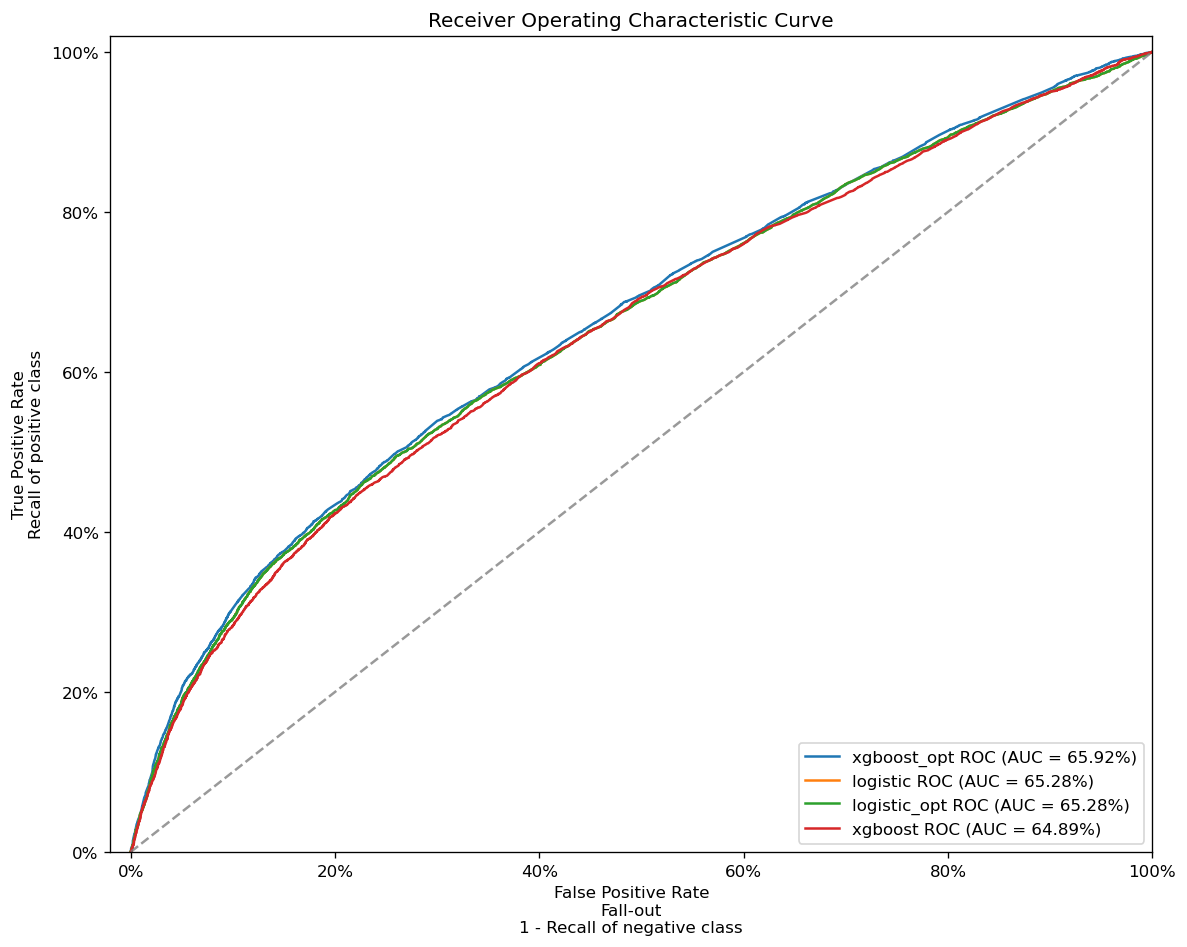

,model,auroc,brier,logloss,f1,precision,recall,accuracy
model_name,,,,,,,,
xgboost_opt,"(ColumnTransformer(transformers=[('numericas',...",0.659237,0.224864,0.641145,0.485117,0.659661,0.383614,0.6402
logistic,"(ColumnTransformer(transformers=[('numericas',...",0.652783,0.226851,0.645626,0.482394,0.65395,0.382143,0.63765
logistic_opt,"(ColumnTransformer(transformers=[('numericas',...",0.652783,0.226852,0.645626,0.482502,0.654017,0.382256,0.6377
xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.648946,0.228863,0.651561,0.489699,0.636051,0.398099,0.6334


In [16]:
modelos_auroc = {}
modelos_auroc.update(modelos)
modelos_auroc.update(opt_modelos)

splt.plot_roc_auc_curve(
    models = modelos_auroc,
    X_test = X_test, y_test = y_test
)

Vemos que o modelo XGBoost parece ser o que mais acuradamente representa as probabilidades previstas.

### Otimização de *threshold* de decisão

Após a análise das probabilidades que o modelo prediz, resta ainda uma pergunta: dada uma probabilidade de o teste ser positivo, qual deve ser o limiar a partir do qual a predição deve ser "teste positivo"?

Para tal, há que se fazer uma análise do "custo" de ocorrer um falso positivo vs um falso negativo.

In [17]:
modelo_final = opt_modelos['xgboost_opt']

y_prob = modelo_final.predict_proba(X_test)[:, 1]

Neste caso, **é mais prejudicial um falso negativo**, *i.e.* prevermos que um paciente receberá um teste negativo quando ele estiver infectado. A consequência para a comunidade é altamente negativa, pois esse paciente pode infectar outras pessoas sem se dar conta que está potencialmente acometido por COVID.

No caso de um falso positivo (prevermos que o paciente receberá um teste positivo quando ele não estiver infectado), o paciente incorre no prejuízo de se isolar desnecessariamente.

In [18]:
def calc_threshold_optimization(y_true, y_prob, beta = 1, calcs = dict()):

    # generate threshold dataframe
    thresholds = pd.DataFrame(np.linspace(0, 1, 101), columns = ['threshold'])

    # calc tn, fp, fn, tp for each threshold
    threshold_conf_mat = thresholds.apply(
            smetrics.calc_confusion_matrix, 
            y_true = y_true, y_prob = y_prob, 
            axis = 1
        )

    threshold_opt = pd.concat([
        thresholds,
        threshold_conf_mat
    ], axis = 1)

    # calc a few other metrics
    threshold_opt['precision'] = (
        (threshold_opt.tp / (threshold_opt.tp + threshold_opt.fp))
            .where(threshold_opt.tp + threshold_opt.fp > 0, np.nan)
    )

    threshold_opt['recall'] = (
        (threshold_opt.tp / (threshold_opt.tp + threshold_opt.fn))
            .where(threshold_opt.tp + threshold_opt.fn > 0, np.nan)
    )

    threshold_opt['accuracy'] = (
        (threshold_opt.tp + threshold_opt.tn) /
        (threshold_opt.tn + threshold_opt.fp + threshold_opt.fn + threshold_opt.tp)
    )

    threshold_opt[f'f{beta:n}_score'] = (
        (
            (1+beta**2) * threshold_opt.precision * threshold_opt.recall /
            (threshold_opt.precision * beta**2 + threshold_opt.recall)
        )
            .where(
                threshold_opt.precision * beta**2 + threshold_opt.recall > 0,
                np.nan
            )
    )

    threshold_opt['cohen_kappa_score'] = np.vectorize(
        lambda threshold: smetrics.calc_cohen_kappa_score(
            y_true = y_true,
            y_prob = y_prob,
            threshold = threshold)
    )(threshold_opt['threshold'])

    for name, fun_config in calcs.items():
        fcalc = fun_config['fcalc']
        kwds = fun_config['kwds']

        fapply = lambda row: fcalc(row, **kwds)

        threshold_opt[name] = threshold_opt.apply(fapply, axis = 1)

        try:
            if fun_config['normalize']:
                colvals = threshold_opt[name]
                threshold_opt[name] = (colvals - colvals.min()) / (colvals.max() - colvals.min())
        except KeyError:
            pass

    # return the dataframe (index is threshold level)
    return threshold_opt.set_index('threshold')

In [19]:
# chamar a função de análise de threshold
# inclui uma coluna com o custo
# custo de cada um [[custo_tn, custo_fp], [custo_fn, custo_tp]]
# caso a função de otimização seja maximização, basta dar o sinal negativo

calcs = {
    'cost': {
        'fcalc': smetrics.calc_confusion_matrix_cost,
        'kwds': {
            'cost_matrix': [[1, -1], [-5, 1]],    # custo de fn é 5 vezes mais alto que custo de fp
        },
        'normalize': True     # custo normalizado para ficar na escala de 0 a 1
    }
}

threshold_opt = calc_threshold_optimization(
    y_true = y_test, 
    y_prob = y_prob,
    calcs = calcs,
    beta = 1.5 # priorizacao do recall sobre o precision
)

threshold_opt

,tn,fp,fn,tp,precision,recall,accuracy,f1.5_score,cohen_kappa_score,cost
threshold,,,,,,,,,,
0.00,0,11163,0,8837,0.44185,1.0,0.44185,0.720108,0.0,0.992691
0.01,0,11163,0,8837,0.44185,1.0,0.44185,0.720108,0.0,0.992691
0.02,0,11163,0,8837,0.44185,1.0,0.44185,0.720108,0.0,0.992691
0.03,0,11163,0,8837,0.44185,1.0,0.44185,0.720108,0.0,0.992691
0.04,0,11163,0,8837,0.44185,1.0,0.44185,0.720108,0.0,0.992691
...,...,...,...,...,...,...,...,...,...,...
0.96,11163,0,8837,0,NaN,0.0,0.55815,NaN,0.0,0.000000
0.97,11163,0,8837,0,NaN,0.0,0.55815,NaN,0.0,0.000000
0.98,11163,0,8837,0,NaN,0.0,0.55815,NaN,0.0,0.000000


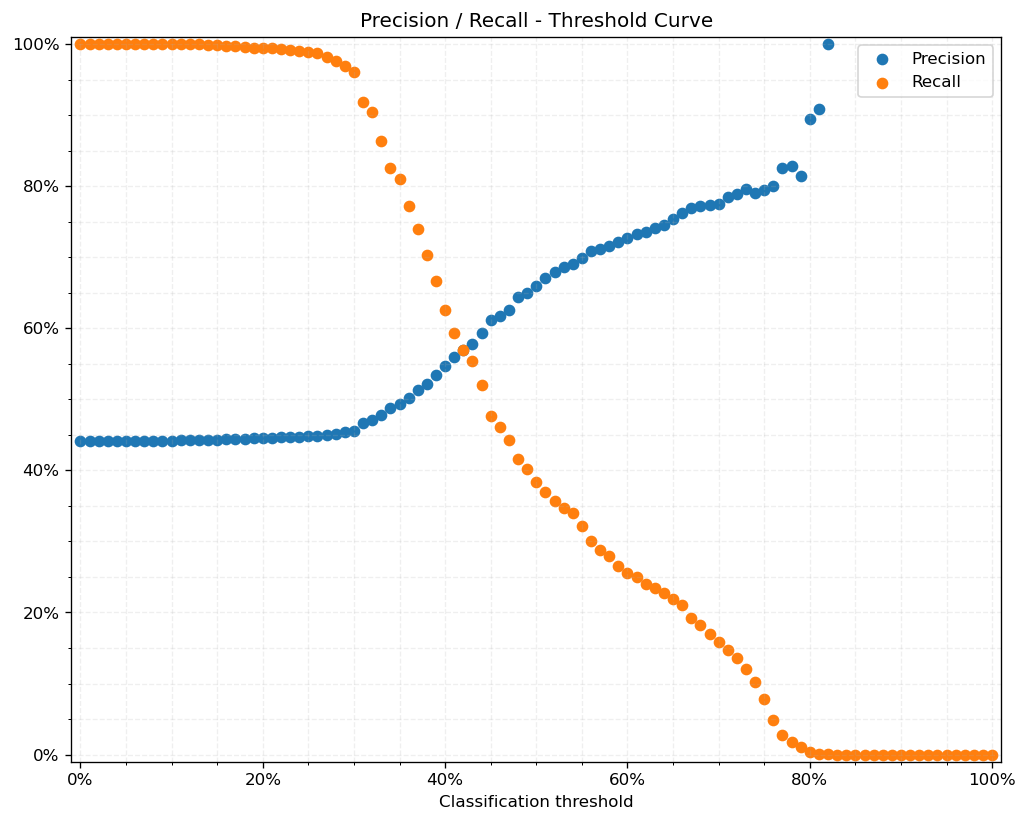

In [20]:
fig = splt.plot_precision_recall_curve(y_true = y_test, y_prob = y_prob)

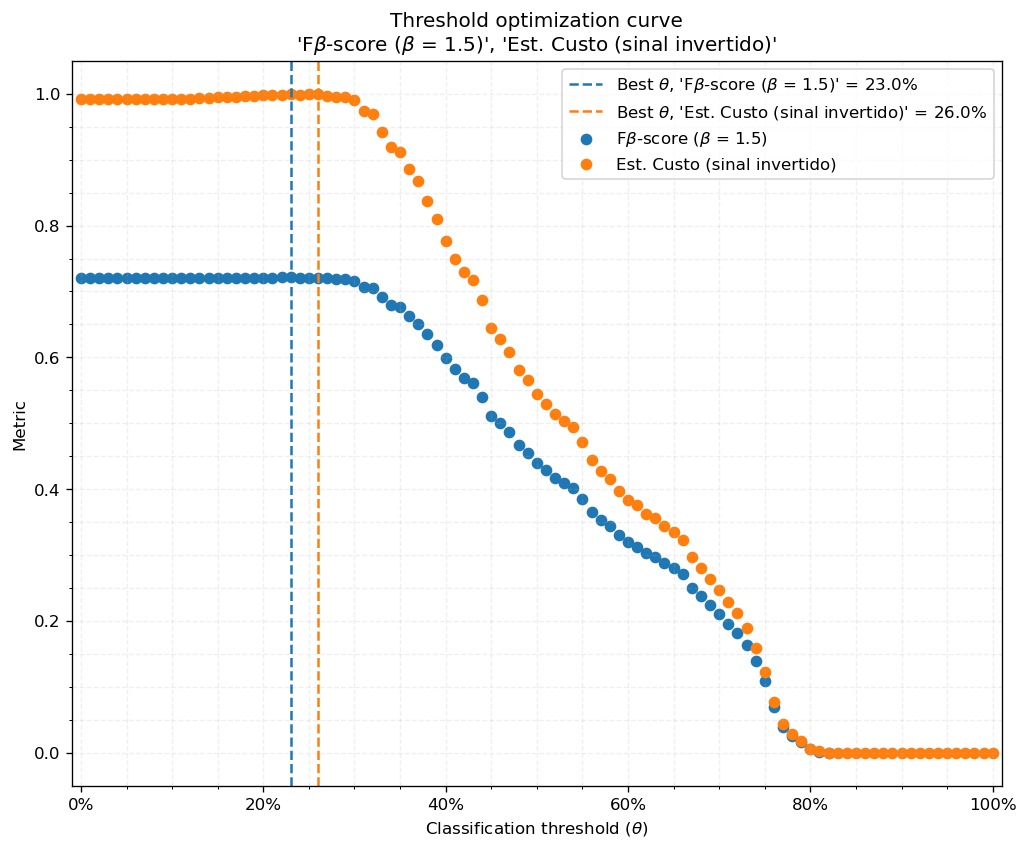

In [21]:
fig = splt.plot_threshold_curve(
    y_true = y_test, y_prob = y_prob,
    threshold_opt = threshold_opt,
    metrics = {
        'f1.5_score': r'F$\beta$-score ($\beta$ = 1.5)',
        'cost': 'Est. Custo (sinal invertido)'
    },
    best_threshold = True,
    minimize = False
)

O gráfico acima evidencia que o *threshold* $\theta$ padrão não é adequado para tomada de decisão.

Segundo a estimativa de custo (em que tomamos por hipótese que o custo de falsos negativos é 5 vezes maior que o custo de falsos positivos), o limiar ideal em que o resultado do modelo passa de "teste negativo" para "teste positivo" é $\theta = 24\%$. Em outras palavras, se a probabilidade de um teste positivo for menor que 24%, predizemos que o teste dará negativo. Já se a probabilidade for maior que 24%, predizemos que o teste dará positivo.

Calculamos também o ***F-beta score*** em função do limiar de decisão. O *F-beta score* é similar ao *F1 score*, ou seja é uma média harmônica entre a precisão e o *recall*. A diferença é que essa média é ponderada, com um fator $\dfrac{1}{\beta _2}$ para a precisão. Logo, se $\beta < 1$, o *F-beta* prioriza a precisão em detrimento do *recall* (mas sem ignorar completamente o mesmo). Caso $\beta > 1$, o *F-beta* passa a priorizar o *recall* (igualmente sem ignorar completamente a precisão).

Como julgamos que os falsos negativos são mais custosos, devemos priorizar o *recall*. Com um valor de $\beta = 1.5$, o ponto em que *F-beta* é máximo corresponde ao *threshold* $\theta = 24\%$, concordando com a análise similar do custo estimado.

Este resultado igual é devido ao patamar que aparece nas curvas, bem como na curva de ***Precision-Recall Threshold***. Com o limiar $0\% < \theta <  \sim 30\%$, a precisão, *recall*, *F-beta* e custo estimado variam pouco. Em outras palavras, temos evidências de que o limiar ótimo está entre $0\%$ e $30\%$, mas não há insumos fortes o suficientes para definirmos categoricamente o *threshold* otimizado.

Se a aplicação desse modelo for insumo para tomada de decisão de médicos, é apropriado apenas citar as probabilidades de um teste positivo de COVID.

No entanto, para aplicações em que o consumidor final é leigo, é mais prudente que a saída do modelo seja uma decisão. Na falta de informações mais definitivas, **estabelecemos o limiar ótimo em $\theta = 24\%$**.

In [22]:
pprint({ k: v for k, v in modelo_final.get_params().items() if k.startswith('xgboost__') })

{'xgboost__base_score': 0.5,
 'xgboost__booster': 'gbtree',
 'xgboost__colsample_bylevel': 1,
 'xgboost__colsample_bynode': 1,
 'xgboost__colsample_bytree': 1,
 'xgboost__criterion': 'friedman_mse',
 'xgboost__enable_categorical': False,
 'xgboost__eval_metric': 'logloss',
 'xgboost__gamma': 0,
 'xgboost__gpu_id': -1,
 'xgboost__importance_type': None,
 'xgboost__interaction_constraints': '',
 'xgboost__learning_rate': 0.1,
 'xgboost__max_delta_step': 0,
 'xgboost__max_depth': 3,
 'xgboost__max_features': 'sqrt',
 'xgboost__min_child_weight': 1,
 'xgboost__missing': nan,
 'xgboost__monotone_constraints': '()',
 'xgboost__n_estimators': 100,
 'xgboost__n_jobs': 8,
 'xgboost__num_parallel_tree': 1,
 'xgboost__objective': 'binary:logistic',
 'xgboost__predictor': 'auto',
 'xgboost__random_state': 42,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 1,
 'xgboost__subsample': 1,
 'xgboost__tree_method': 'exact',
 'xgboost__use_label_encoder': True,
 'xgboos

In [24]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

y_pred_threshold = (y_prob >= 0.24) * (1)

metricas_args = [y_test, y_pred_threshold]

metricas_threshold = {
    'f1': f1_score(*metricas_args),
    'precision': precision_score(*metricas_args),
    'recall': recall_score(*metricas_args),
    'accuracy': accuracy_score(*metricas_args)
}

pprint(metricas_threshold)

{'accuracy': 0.4549,
 'f1': 0.6162348634187553,
 'precision': 0.4472433702927801,
 'recall': 0.9904945117121196}
